GroupIdを指定して、その中のSensoridすべてを調べる


In [31]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


# .env 読み込み
print(r"..\environment\.env")
load_dotenv(dotenv_path=r'..\environment/.env',override=True)

# =========================
# 🔐 Metabase 認証・データ取得
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("❌ MB_USERNAME または MB_PASSWORD が設定されていません")

print(f"ログイン試行中 → username: '{username}'")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("✅ ログイン成功")
else:
    raise Exception(f"❌ ログイン失敗: {response.status_code}, {response.text}")


..\environment\.env
ログイン試行中 → username: 'y-nitta@torishima.co.jp'
✅ ログイン成功


groupId指定

In [32]:

# データ取得
url = "https://metabase.tr-com.net/api/card/2097/query/json"
headers = {
    "Content-Type": "application/json",
    "X-Metabase-Session": session_id
}

# Payload
payload = {
    "parameters": [
        {
            "type": "category",
            "target": ["variable", ["template-tag", "GroupId"]],
            "value": "394"
        }
    ]
}

response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    try:
        data = response.json()
        dfgroupId = pd.DataFrame(data)
        if dfgroupId.empty:
            raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")
        print("✅ データ取得成功")
        print(dfgroupId.head())

    except Exception as e:
        raise Exception(f"❌ データ取得・DataFrame変換失敗: {e}")
else:
    raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")


✅ データ取得成功
   GroupId   GroupName  SensorId  ParentGroupId GroupType
0      394  丸の内熱供給株式会社  VB0F4E10           1290         C
1      394  丸の内熱供給株式会社  VB0FFF8A           1290         C
2      394  丸の内熱供給株式会社  VB35B2D8           1290         C
3      394  丸の内熱供給株式会社  VB35E4EE           1290         C
4      394  丸の内熱供給株式会社  VB35EC56           1290         C


In [33]:
import requests
import pandas as pd
import numpy as np

def analyze_sensor_data(sensor_id, session_id):
    """
    指定された sensor_id の時系列データを取得し、大きい順に並べて、
    それぞれのデータが上から何％の位置にいるかを付与する。

    Parameters:
        sensor_id (str): 対象センサーID
        session_id (str): MetabaseのセッションID

    Returns:
        pd.DataFrame: record_date, GroupId, SensorId, x_vrmsacc, percentile_from_top（％）
    """

    # Metabase APIでデータ取得
    url = "https://metabase.tr-com.net/api/card/2092/query/json"
    headers = {
        "Content-Type": "application/json",
        "X-Metabase-Session": session_id
    }
    payload = {
        "parameters": [
            {
                "type": "category",
                "target": ["variable", ["template-tag", "sensorid"]],
                "value": sensor_id
            }
        ]
    }

    response = requests.post(url, headers=headers, json=payload)
    if response.status_code != 200:
        raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")

    data = response.json()
    df_sensor_data = pd.DataFrame(data)
    if df_sensor_data.empty:
        raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")

    df = df_sensor_data.copy()
    df['record_date'] = pd.to_datetime(df['record_date'])
    df = df[['record_date', 'GroupId', 'SensorId', 'x_vrmsacc']].dropna()
    
    mean = df['x_vrmsacc'].mean()
    std = df['x_vrmsacc'].std()
    df = df[(df['x_vrmsacc'] >= mean - 3*std) & (df['x_vrmsacc'] <= mean + 3*std)]

    # 3σ除外
    mean = df['x_vrmsacc'].mean()
    std = df['x_vrmsacc'].std()
    df = df[(df['x_vrmsacc'] >= mean - 3*std) & (df['x_vrmsacc'] <= mean + 3*std)]

    # 3σ除外後の最小・最大
    min_val = df['x_vrmsacc'].min()
    max_val = df['x_vrmsacc'].max()

    # Min-Max正規化
    df['x_vrmsacc_minmax'] = (df['x_vrmsacc'] - min_val) / (max_val - min_val)


    return df


In [34]:
results = []


for i in range(1):

    sensor_id = dfgroupId["SensorId"].iloc[i]
    print(f"🔎 処理中 SensorId: {sensor_id}")
    
    try:
        df_result = analyze_sensor_data(sensor_id, session_id)
        results.append(df_result)
    
    except Exception as e:
        print(f"❌ SensorId {sensor_id} の処理中にエラー: {e}")

# すべての結果を結合
if results:
    df_all_results = pd.concat(results, ignore_index=True)

    # record_dateで昇順ソート
    df_all_results = df_all_results.sort_values(by="record_date").reset_index(drop=True)

    print("✅ 全センサー分の集計結果（record_date順）:")
    print(df_all_results.head(20))

else:
    print("❗ 結果が空です。")



🔎 処理中 SensorId: VB0F4E10
✅ 全センサー分の集計結果（record_date順）:
           record_date  GroupId  SensorId  x_vrmsacc  x_vrmsacc_minmax
0  2019-09-03 04:36:50      394  VB0F4E10  19.291339          0.045790
1  2019-09-03 05:36:50      394  VB0F4E10  20.472441          0.050222
2  2019-09-03 06:36:50      394  VB0F4E10  20.472441          0.050222
3  2019-09-03 07:36:50      394  VB0F4E10  20.472441          0.050222
4  2019-09-03 08:36:50      394  VB0F4E10  20.472441          0.050222
5  2019-09-03 09:36:50      394  VB0F4E10  20.472441          0.050222
6  2019-09-03 10:36:50      394  VB0F4E10  20.472441          0.050222
7  2019-09-03 11:36:50      394  VB0F4E10  20.078740          0.048744
8  2019-09-03 12:36:50      394  VB0F4E10  20.472441          0.050222
9  2019-09-03 13:36:50      394  VB0F4E10  20.472441          0.050222
10 2019-09-03 14:36:50      394  VB0F4E10  20.472441          0.050222
11 2019-09-03 15:36:50      394  VB0F4E10  20.866142          0.051699
12 2019-09-03 16:36:50 

In [35]:
results = []


for i in range(len(dfgroupId)):

    sensor_id = dfgroupId["SensorId"].iloc[i]
    print(f"🔎 処理中 SensorId: {sensor_id}")
    
    try:
        df_result = analyze_sensor_data(sensor_id, session_id)
        results.append(df_result)
    
    except Exception as e:
        print(f"❌ SensorId {sensor_id} の処理中にエラー: {e}")

# すべての結果を結合
if results:
    df_all_results = pd.concat(results, ignore_index=True)

    # record_dateで昇順ソート
    df_all_results = df_all_results.sort_values(by="record_date").reset_index(drop=True)

    print("✅ 全センサー分の集計結果（record_date順）:")
    print(df_all_results.head(20))

else:
    print("❗ 結果が空です。")



🔎 処理中 SensorId: VB0F4E10
🔎 処理中 SensorId: VB0FFF8A
🔎 処理中 SensorId: VB35B2D8
🔎 処理中 SensorId: VB35E4EE
🔎 処理中 SensorId: VB35EC56
🔎 処理中 SensorId: VB360E56
🔎 処理中 SensorId: VB367893
🔎 処理中 SensorId: VB36905C
🔎 処理中 SensorId: VB36BB69
🔎 処理中 SensorId: VB36C082
🔎 処理中 SensorId: VB3727C1
🔎 処理中 SensorId: VB3772E8
🔎 処理中 SensorId: VB37B493
🔎 処理中 SensorId: VB37D804
🔎 処理中 SensorId: VB38A2A9
🔎 処理中 SensorId: VB38CBFA
🔎 処理中 SensorId: VB38E704
🔎 処理中 SensorId: VB38F8AA
🔎 処理中 SensorId: VB38F94F
🔎 処理中 SensorId: VB391991
🔎 処理中 SensorId: VB393428
🔎 処理中 SensorId: VB39660F
🔎 処理中 SensorId: VB39BA0C
🔎 処理中 SensorId: VB39E429
❌ SensorId VB39E429 の処理中にエラー: time data "2023-04-09" doesn't match format "%Y-%m-%dT%H:%M:%S", at position 27170. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element indi

percentile_from_topの数字だけでなく、可視化してみるほうがいい


In [36]:
df_all_results

,record_date,GroupId,SensorId,x_vrmsacc,x_vrmsacc_minmax
0,2019-09-03 02:04:11,394,VB3B0CCF,32.283465,0.811594
1,2019-09-03 02:10:44,394,VB360E56,49.212598,0.701299
2,2019-09-03 02:18:13,394,VB3A5CB2,34.645669,0.845070
3,2019-09-03 02:23:55,394,VB391991,33.070866,0.216828
4,2019-09-03 02:26:50,394,VB3772E8,29.527559,0.204918
...,...,...,...,...,...
1624375,2025-06-08 04:48:02,394,VB36BB69,13.385827,0.086207
1624376,2025-06-08 04:48:20,394,VB36BB69,13.385827,0.086207
1624377,2025-06-08 04:48:52,394,VB3772E8,89.763780,0.831967
1624378,2025-06-08 04:49:23,394,VB39BA0C,14.960630,0.009756


In [37]:
# record_date を datetime に変換（念のため）
df_all_results['record_date'] = pd.to_datetime(df_all_results['record_date'])

# record_date をインデックスに（resample用）
df_resampled = df_all_results.set_index('record_date')

# 1時間ごとの平均を計算
df_hourly = df_resampled['x_vrmsacc_minmax'].resample('1H').mean().reset_index()

# 表示（例：先頭10行）
print(df_hourly.head(10))


          record_date  x_vrmsacc_minmax
0 2019-09-03 02:00:00          0.369118
1 2019-09-03 03:00:00          0.190808
2 2019-09-03 04:00:00          0.270008
3 2019-09-03 05:00:00          0.158136
4 2019-09-03 06:00:00          0.166494
5 2019-09-03 07:00:00          0.157022
6 2019-09-03 08:00:00          0.158570
7 2019-09-03 09:00:00          0.157797
8 2019-09-03 10:00:00          0.162354
9 2019-09-03 11:00:00          0.165961


C:\Users\H6445\AppData\Local\Temp\ipykernel_2852\2529586598.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_resampled['x_vrmsacc_minmax'].resample('1H').mean().reset_index()


In [38]:
df_hourly

,record_date,x_vrmsacc_minmax
0,2019-09-03 02:00:00,0.369118
1,2019-09-03 03:00:00,0.190808
2,2019-09-03 04:00:00,0.270008
3,2019-09-03 05:00:00,0.158136
4,2019-09-03 06:00:00,0.166494
...,...,...
50518,2025-06-08 00:00:00,0.241453
50519,2025-06-08 01:00:00,0.309023
50520,2025-06-08 02:00:00,0.310650
50521,2025-06-08 03:00:00,0.313696


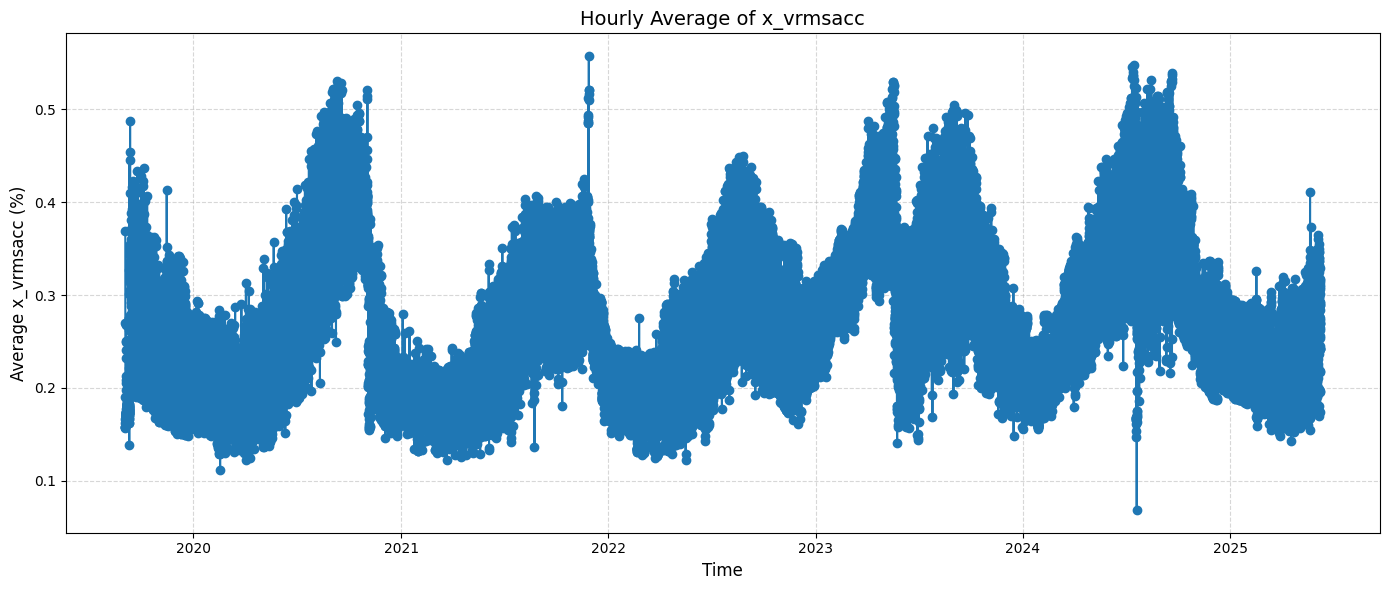

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_hourly['record_date'], df_hourly['x_vrmsacc_minmax'], marker='o', linewidth=1.5)

plt.title("Hourly Average of x_vrmsacc", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Average x_vrmsacc (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


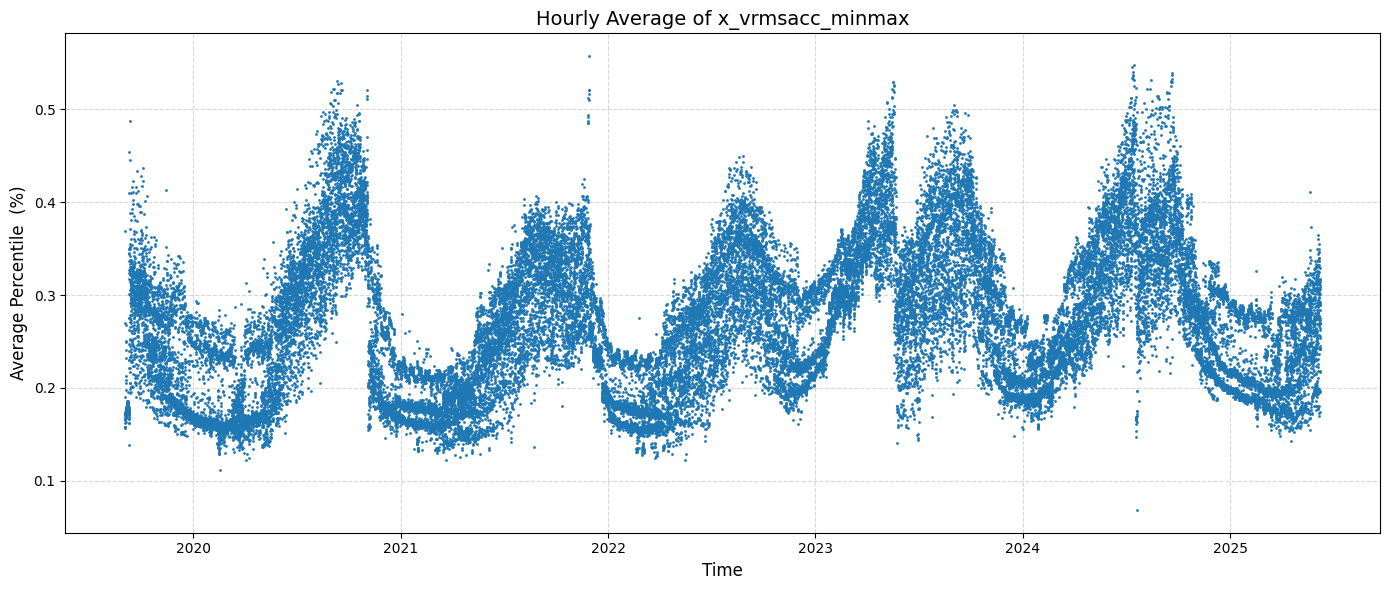

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# 線を消して点だけに
plt.plot(df_hourly['record_date'], df_hourly['x_vrmsacc_minmax'], 
         marker='o', linestyle='None', markersize=1)

plt.title("Hourly Average of x_vrmsacc_minmax", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Average Percentile  (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


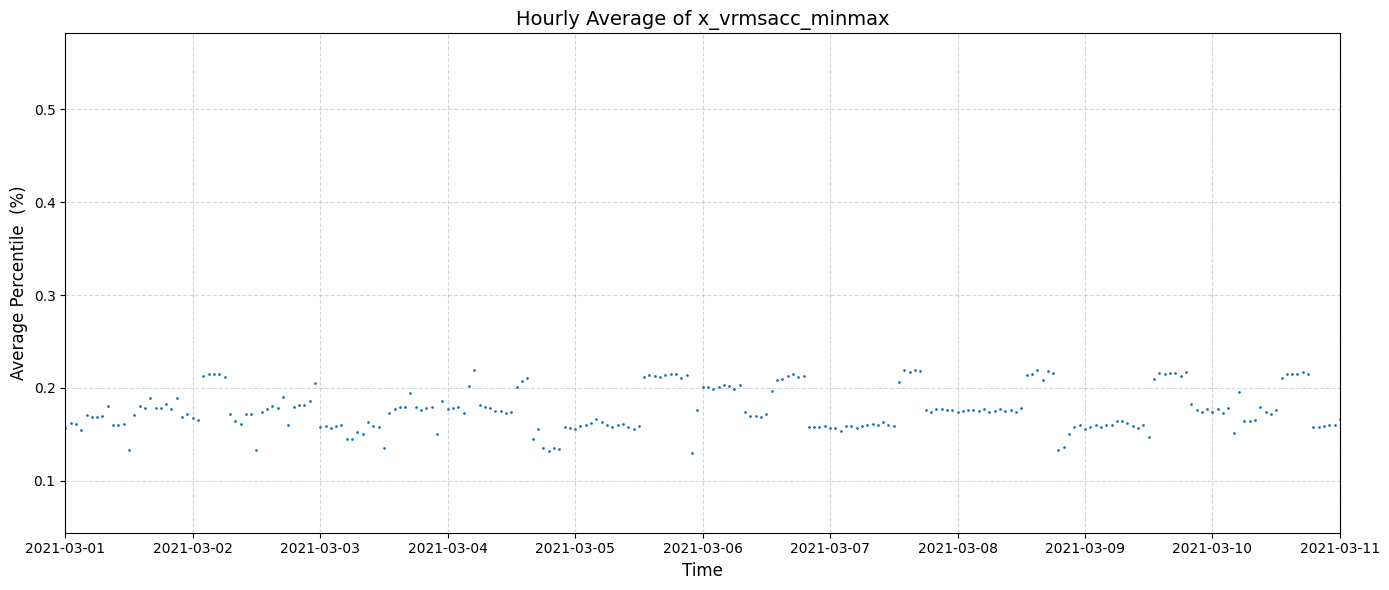

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# 線を消して点だけに
plt.plot(df_hourly['record_date'], df_hourly['x_vrmsacc_minmax'], 
         marker='o', linestyle='None', markersize=1)

plt.title("Hourly Average of x_vrmsacc_minmax", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Average Percentile  (%)", fontsize=12)
plt.xlim(pd.to_datetime("2021-03-01"), pd.to_datetime("2021-03-11"))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


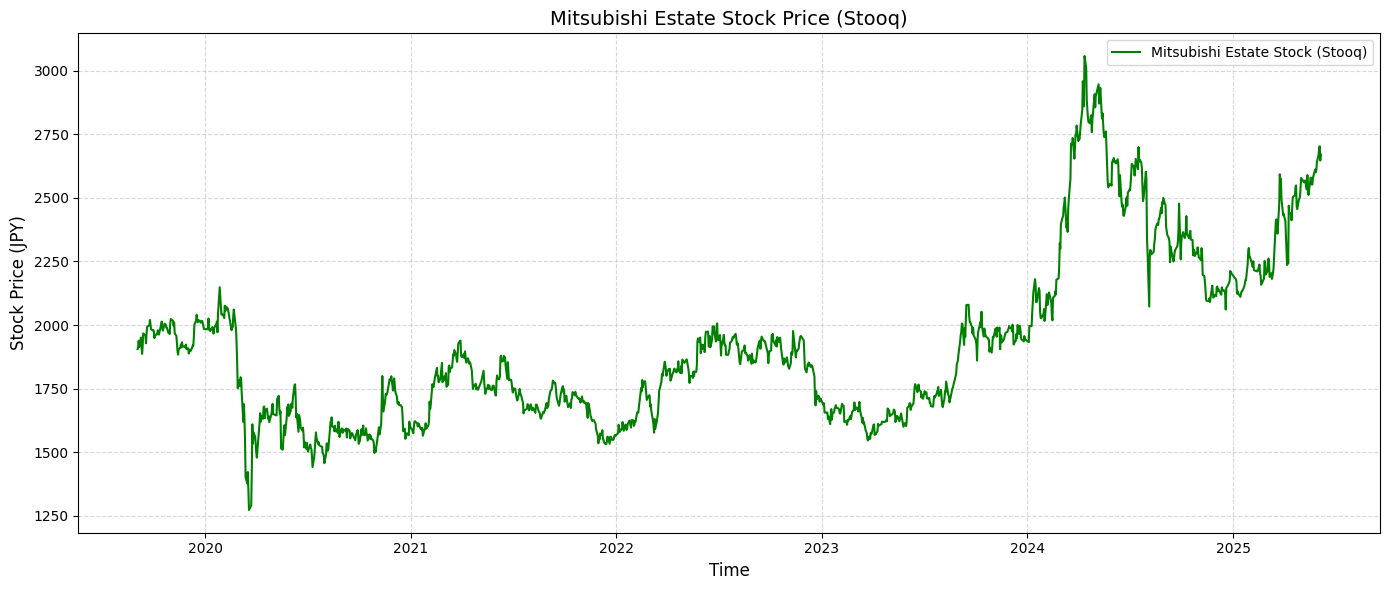

In [42]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd

# record_date の範囲に合わせる（df_hourly が既に存在している前提）
start_date = df_hourly['record_date'].min().date()
end_date = df_hourly['record_date'].max().date()

# Stooq から三菱地所（8802.T）を取得（Stooqでは '.JP' が使われる場合も）
stock_df = web.DataReader("8802.JP", 'stooq', start=start_date, end=end_date)

# 日付を昇順にソート
stock_df = stock_df.sort_index()

# インデックスを列に変換して record_date に統一
stock_df = stock_df.reset_index().rename(columns={"Date": "record_date", "Close": "stock_close"})

# グラフの描画
plt.figure(figsize=(14, 6))
plt.plot(stock_df['record_date'], stock_df['stock_close'], color='green', label='Mitsubishi Estate Stock (Stooq)')

plt.title("Mitsubishi Estate Stock Price (Stooq)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Price (JPY)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
# 両データを日付で結合（inner join）
df_corr = pd.merge(df_hourly, stock_df, on='record_date', how='inner')

# 欠損値がある場合は除去（念のため）
df_corr = df_corr.dropna(subset=['x_vrmsacc_minmax', 'stock_close'])

# 相関係数を計算
correlation = df_corr['x_vrmsacc_minmax'].corr(df_corr['stock_close'])

print(f"📈 相関係数（x_vrmsacc_minmax vs stock_close）: {correlation:.4f}")


📈 相関係数（x_vrmsacc_minmax vs stock_close）: 0.0465
